In [117]:
import pandas as pd
import pickle
import keras
import numpy as np
import matplotlib.pyplot as plt
from pyne import material
from pyne import data

In [118]:
ann_model = pickle.load(open('ann_model.pkl', 'rb'))
half_life_dict = {}
for iso in ann_model['iso_list']:
    half_life_dict[iso] = data.half_life(iso) / (3600 * 24 * 365)

half_life_dict = {k:v for k,v in half_life_dict.items() if v != np.inf}
half_life_dict

{'u-238': 4471060273.972603,
 'u-235': 704482191.7808219,
 'pu-239': 24126.513698630137,
 'u-236': 23436041.09589041,
 'xe-136': 3.602465753424658e+20,
 'pu-240': 6565.493835616438,
 'xe-134': 5.803972602739725e+22,
 'cs-137': 30.10060273972603,
 'pu-241': 14.338814383561646,
 'ce-142': 5.003424657534246e+16,
 'mo-100': 7.305e+18,
 'nd-144': 2291568493150685.0,
 'zr-96': 2.0013698630136988e+19,
 'tc-99': 211244.5890410959,
 'pu-242': 375256.8493150685,
 'zr-93': 1611102.7397260275,
 'sr-90': 28.80971917808219,
 'ce-144': 0.7805753424657536,
 'np-237': 2145468.493150685,
 'te-130': 7.90541095890411e+20,
 'pd-107': 6504452.05479452,
 'ru-106': 1.0186301369863013,
 'cs-135': 2301575.342465753,
 'rb-87': 49734041095.89041,
 'am-243': 7369.043835616439,
 'nd-150': 9.106232876712329e+18,
 'pu-238': 87.76006849315068,
 'cs-134': 2.066614520547945,
 'pm-147': 2.625196849315069,
 'i-129': 15710753.424657535,
 'cm-244': 18.112397260273973,
 'np-239': 0.006454794520547945,
 'sm-148': 700479452054

In [119]:
df = pd.read_csv(open('all.csv', 'r'), index_col=0)
df = df.fillna(0)

In [120]:
# add total assembly decay heat and activity
dh_list = []
ac_list = []
for indx,row in df.iterrows():
    comp_dict = row.to_dict()
    del comp_dict['init_enr']
    del comp_dict['bu']
    mat = material.Material(comp_dict)
    # decay
    mat = mat.decay(3600 * 24 * 365)
    dh_list.append(np.nansum(list(material.Material.decay_heat(mat).values())))
    ac_list.append(np.nansum(list(material.Material.activity(mat).values())))

df['decay heat'] = dh_list
df['activity'] = ac_list

In [121]:
bu_enr = df[['init_enr', 'bu']].values

In [122]:
predict_dict = {'bu': bu_enr[:,1],
                'init_enr': bu_enr[:,0]}
x = ann_model['xscaler'].transform(bu_enr)
y = ann_model['model'].predict(x)
y = ann_model['yscaler'].inverse_transform(y)
for indx, iso in enumerate(ann_model['iso_list']):
    predict_dict[iso] = y[:, indx]
predict_df = pd.DataFrame.from_dict(predict_dict)

In [123]:
# add total assembly decay heat and activity
dh_list = []
ac_list = []
for indx,row in predict_df.iterrows():
    comp_dict = row.to_dict()
    del comp_dict['init_enr']
    del comp_dict['bu']
    mat = material.Material(comp_dict)
    # decay
    mat = mat.decay(3600 * 24 * 365)
    dh_list.append(np.nansum(list(material.Material.decay_heat(mat).values())))
    ac_list.append(np.nansum(list(material.Material.activity(mat).values())))

predict_df['decay heat'] = dh_list
predict_df['activity'] = ac_list

Comparing u-238


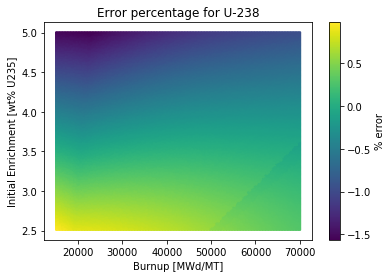

Comparing u-235


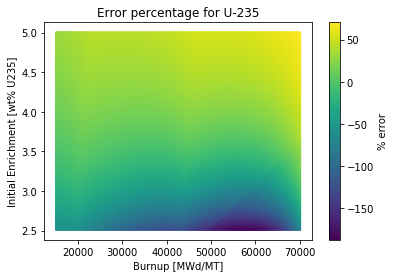

Comparing pu-239


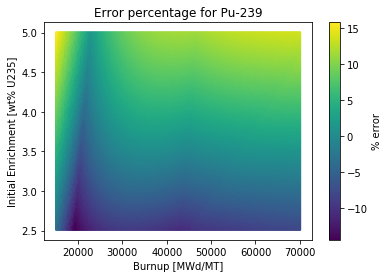

Comparing u-236


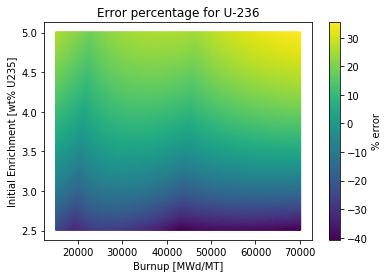

Comparing xe-136


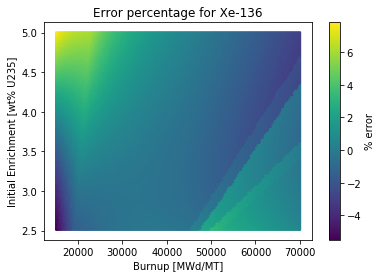

Comparing pu-240


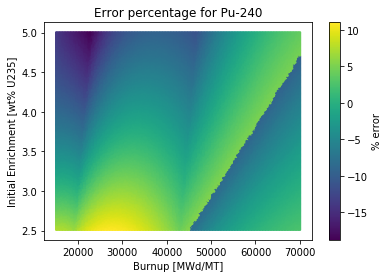

Comparing xe-134


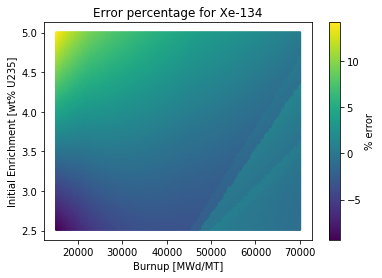

Comparing ba-138


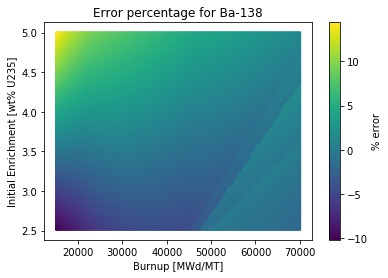

Comparing cs-137


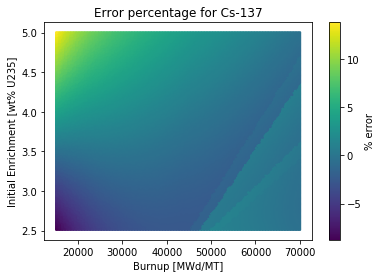

Comparing pu-241


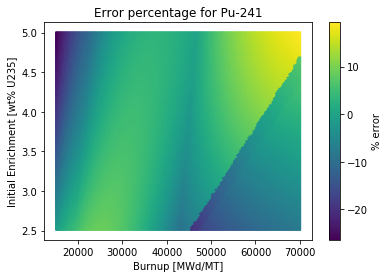

Comparing la-139


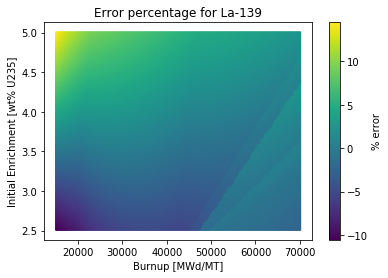

Comparing ce-140


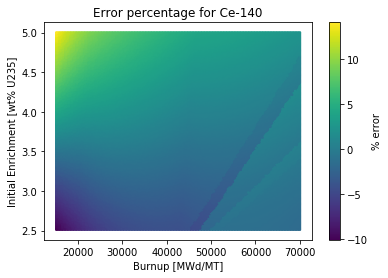

Comparing xe-132


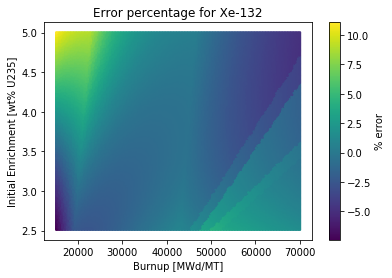

Comparing ce-142


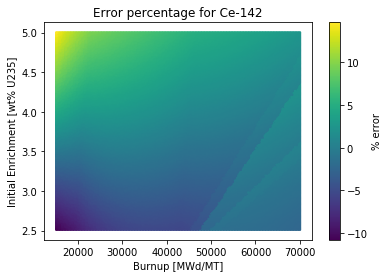

Comparing cs-133


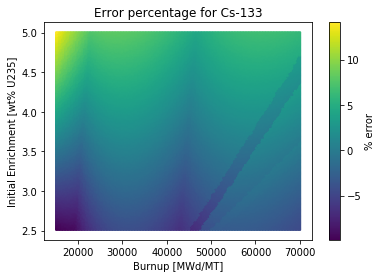

Comparing pr-141


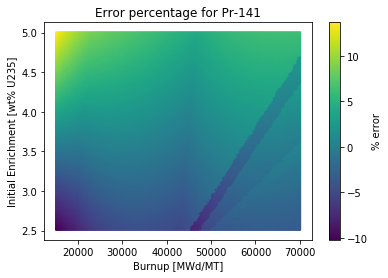

Comparing mo-100


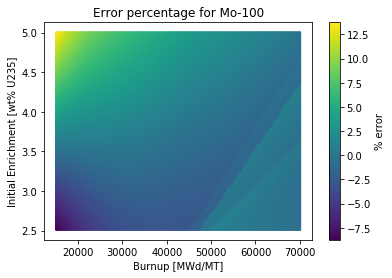

Comparing nd-144


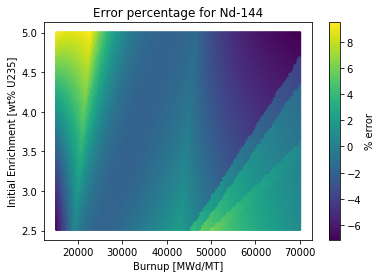

Comparing ru-102


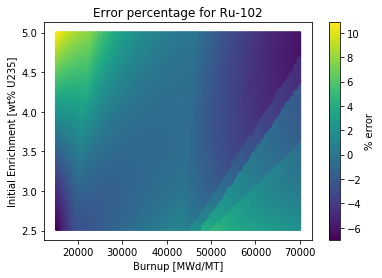

Comparing mo-98


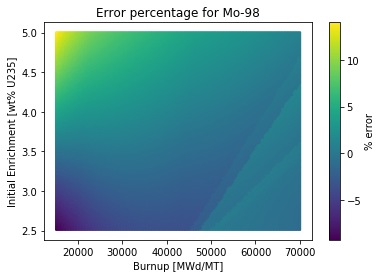

Comparing zr-96


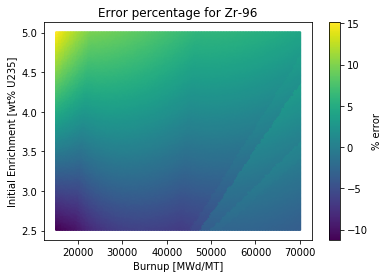

Comparing mo-97


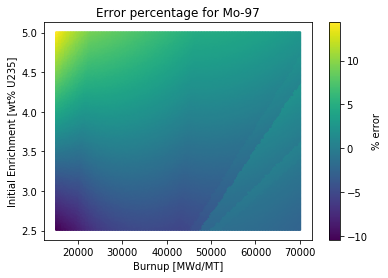

Comparing ru-101


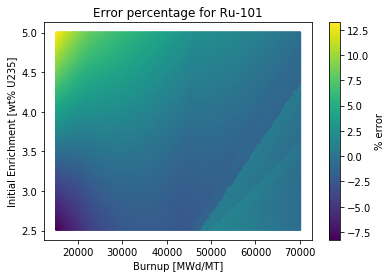

Comparing tc-99


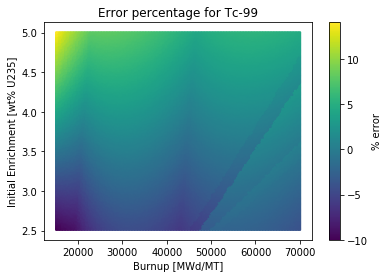

Comparing zr-94


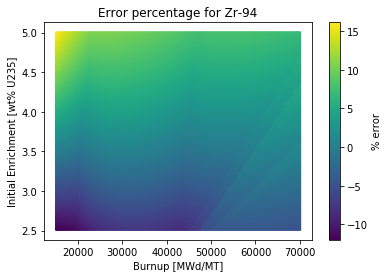

Comparing nd-146


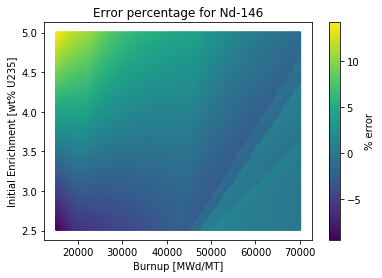

Comparing pu-242


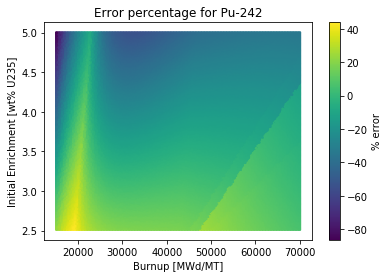

Comparing zr-93


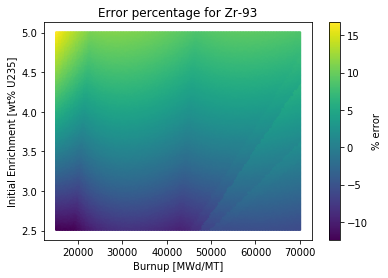

Comparing nd-143


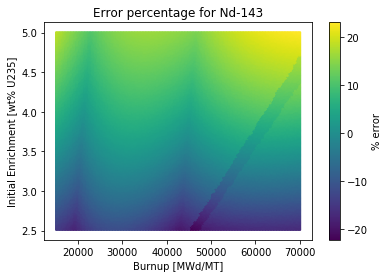

Comparing nd-145


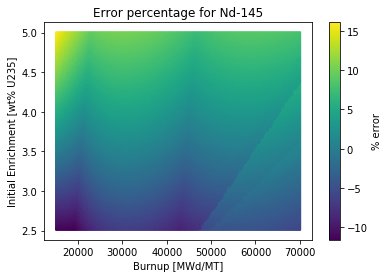

Comparing mo-95


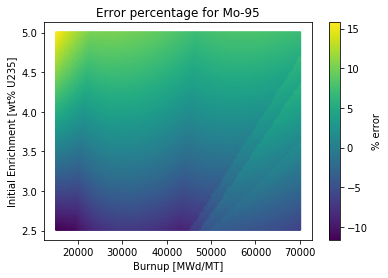

Comparing ru-104


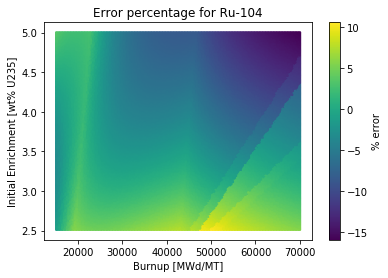

Comparing zr-92


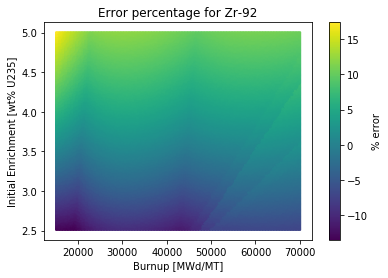

Comparing sr-90


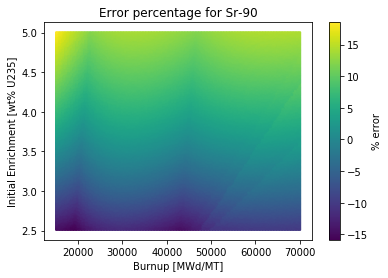

Comparing ce-144


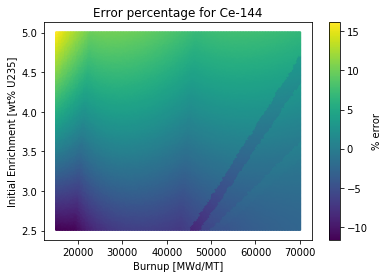

Comparing zr-91


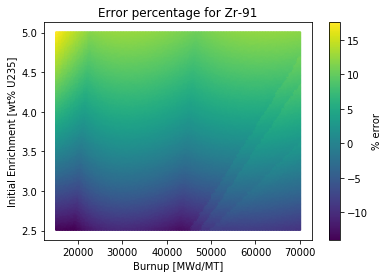

Comparing rh-103


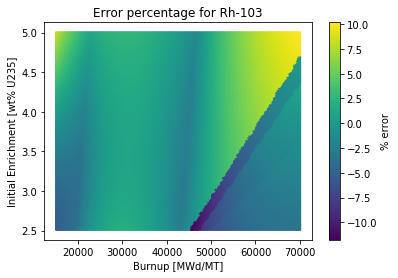

Comparing y-89


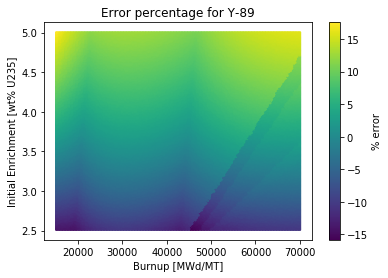

Comparing nd-148


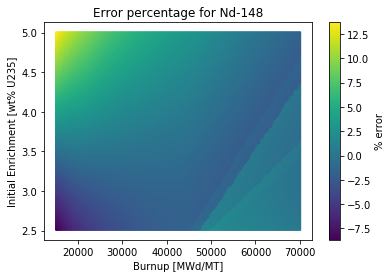

Comparing np-237


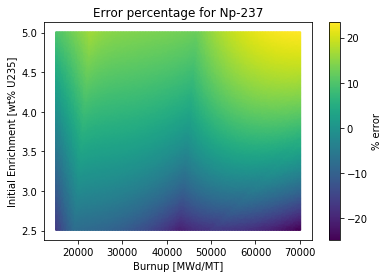

Comparing te-130


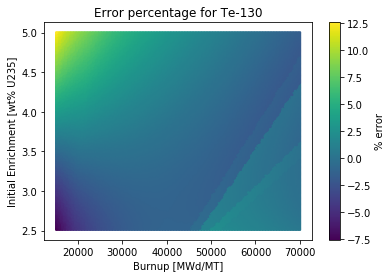

Comparing pd-105


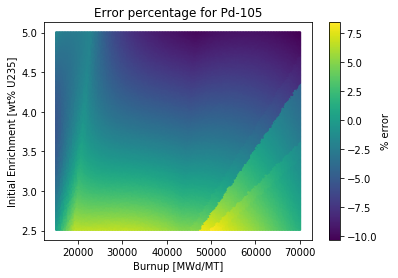

Comparing xe-131


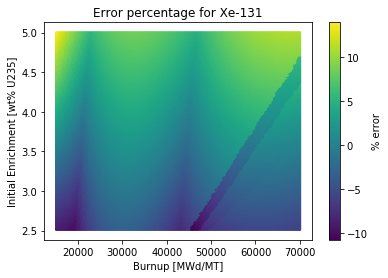

Comparing sr-88


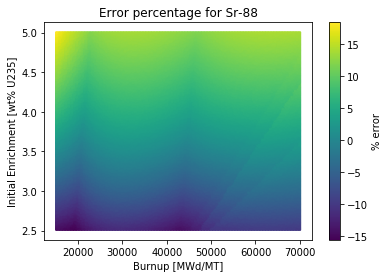

Comparing sm-150


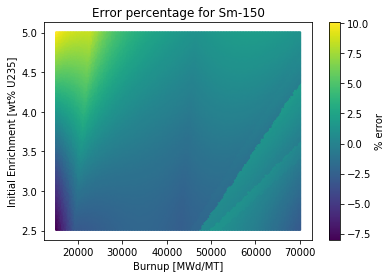

Comparing pd-104


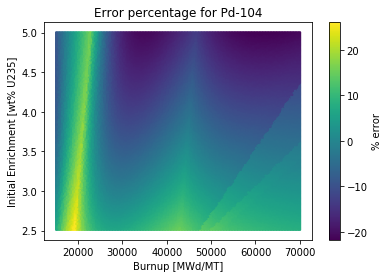

Comparing pd-107


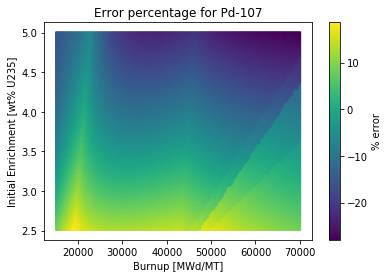

Comparing pd-106


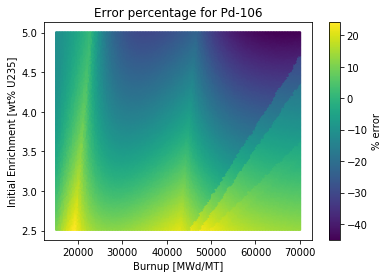

Comparing ru-106


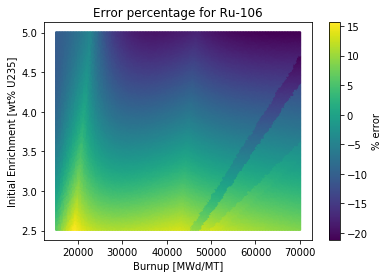

Comparing cs-135


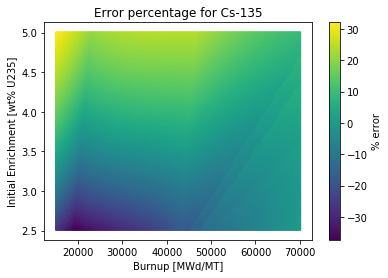

Comparing rb-87


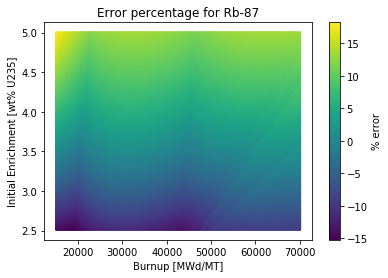

Comparing am-243


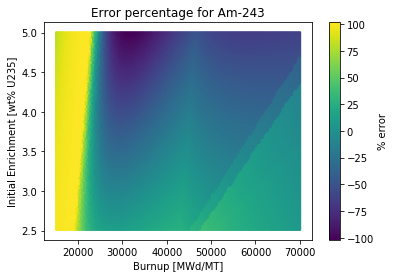

Comparing nd-150


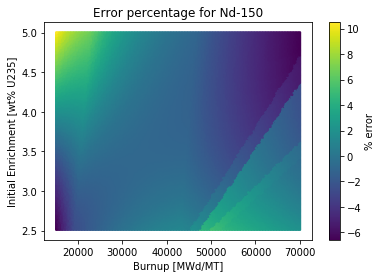

Comparing pu-238


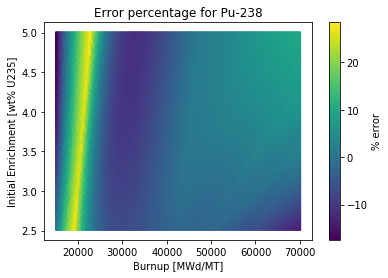

Comparing cs-134


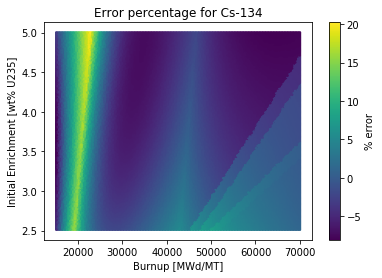

Comparing kr-86


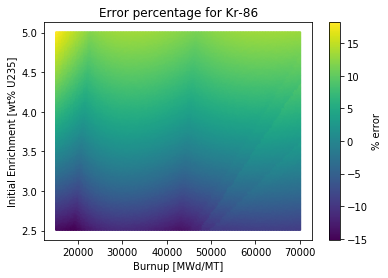

Comparing pd-108


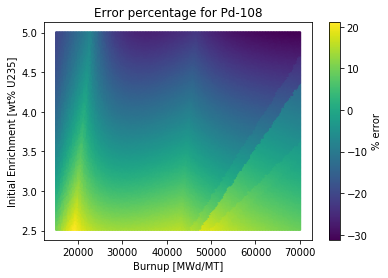

Comparing pm-147


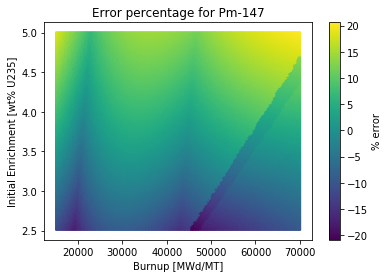

Comparing i-129


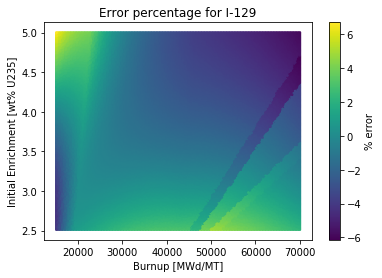

Comparing cm-244


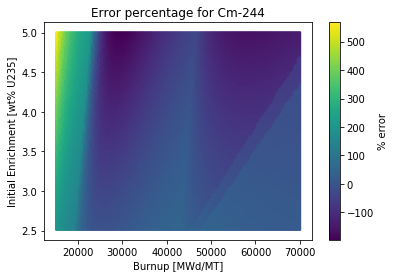

Comparing gd-156


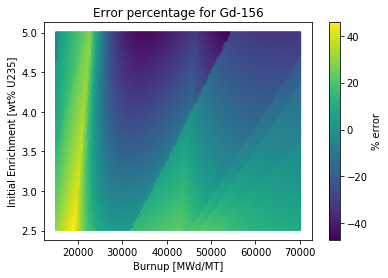

Comparing np-239


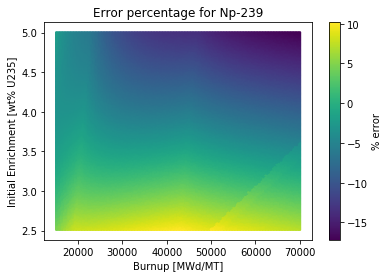

Comparing ru-100


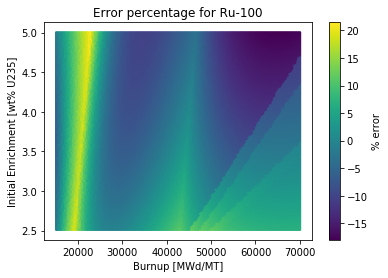

Comparing sm-148


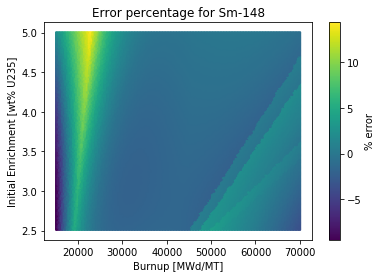

Comparing eu-153


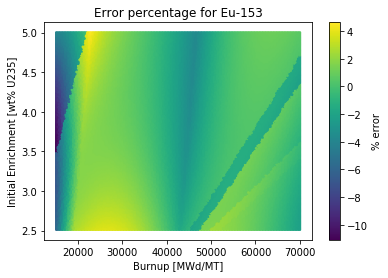

Comparing kr-84


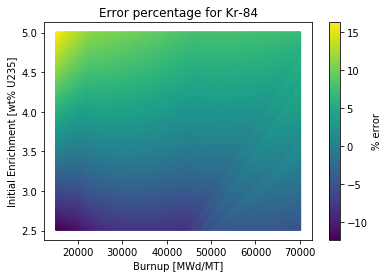

Comparing zr-95


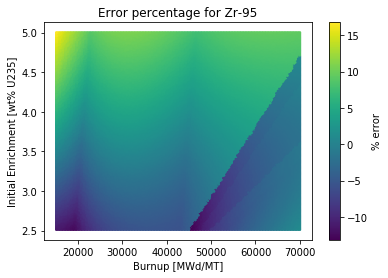

Comparing te-128


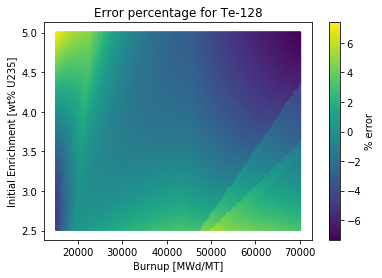

Comparing sm-152


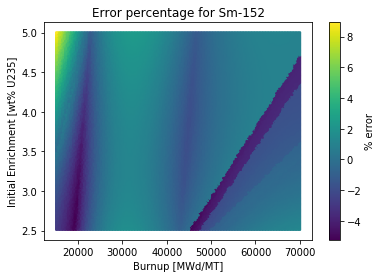

Comparing rb-85


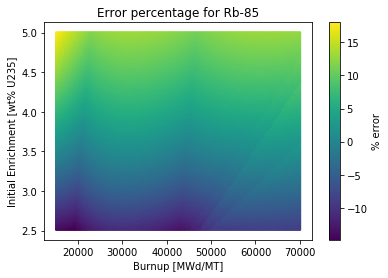

Comparing ag-109


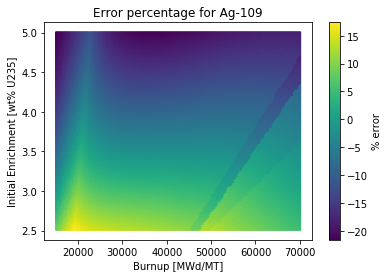

Comparing ce-141


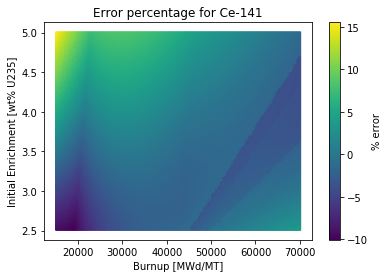

Comparing ru-103


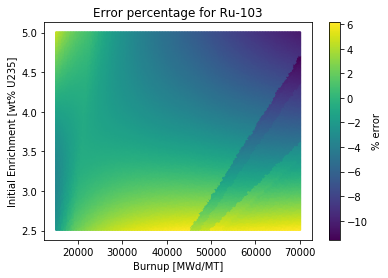

Comparing y-91


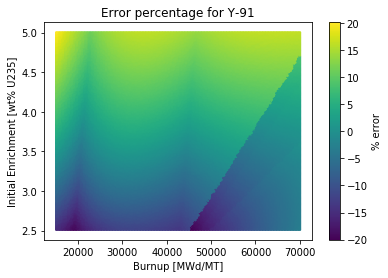

Comparing cd-110


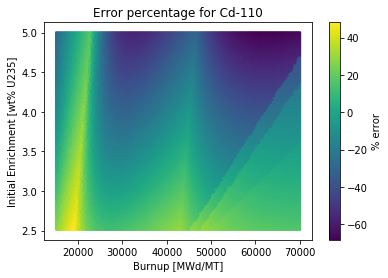

Comparing pd-110


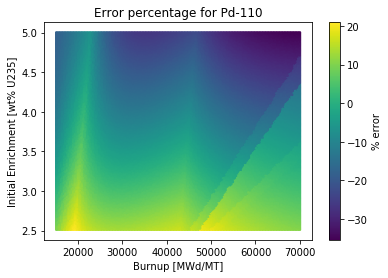

Comparing nb-95


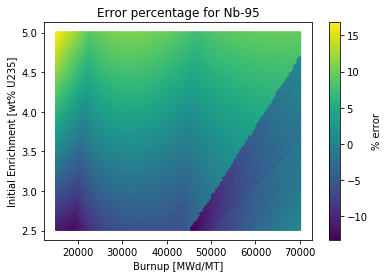

Comparing mo-96


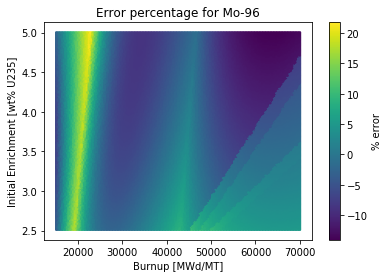

Comparing sm-154


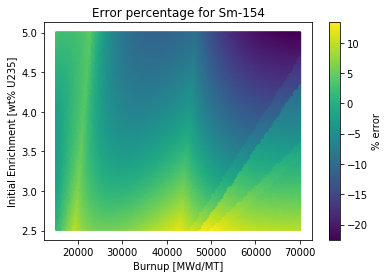

Comparing i-127


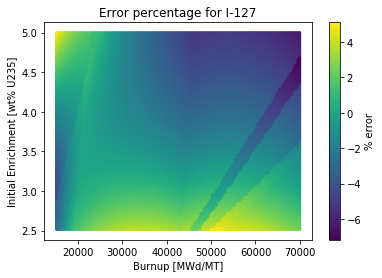

Comparing ba-134


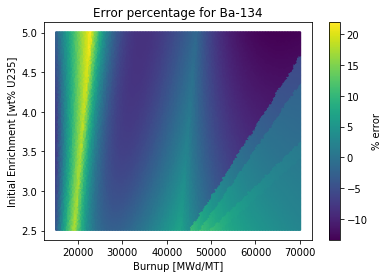

Comparing kr-83


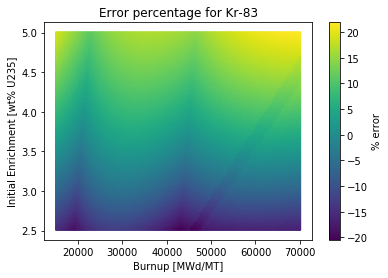

Comparing sm-147


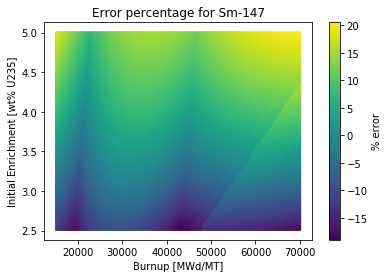

Comparing sr-89


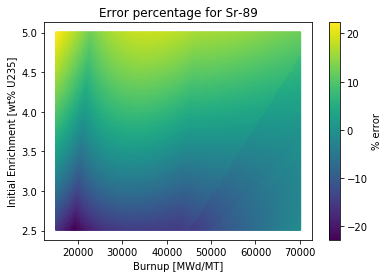

Comparing gd-158


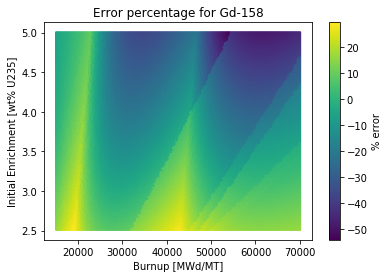

Comparing ba-140


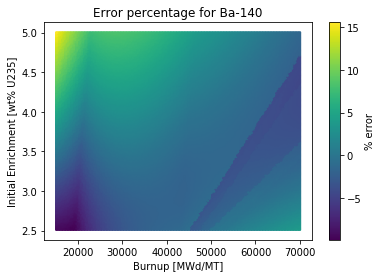

Comparing se-82


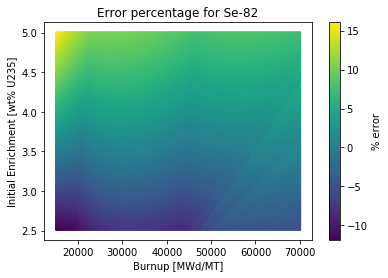

Comparing cd-111


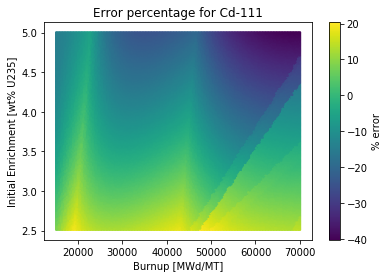

Comparing pr-143


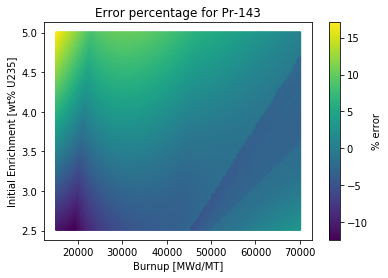

Comparing nd-142


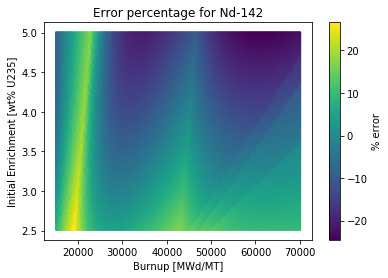

Comparing eu-154


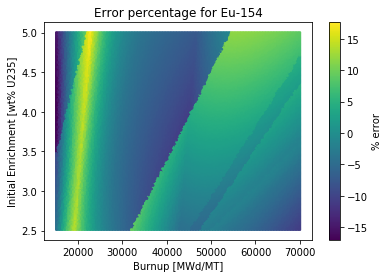

Comparing kr-85


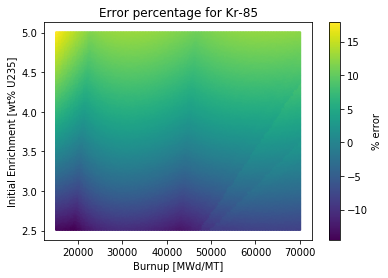

Comparing ba-137


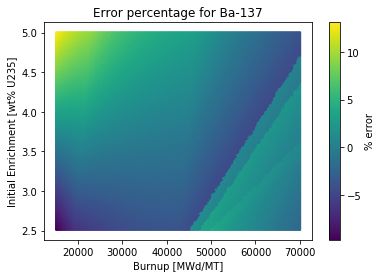

Comparing sn-126


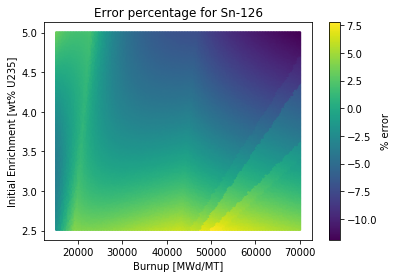

Comparing br-81


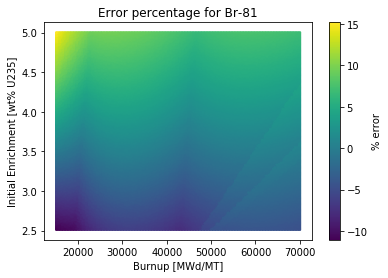

Comparing am-241


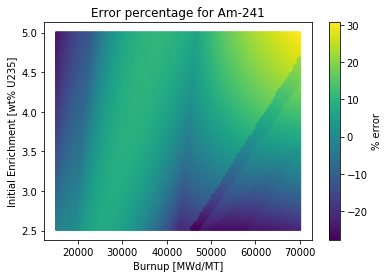

Comparing cd-114


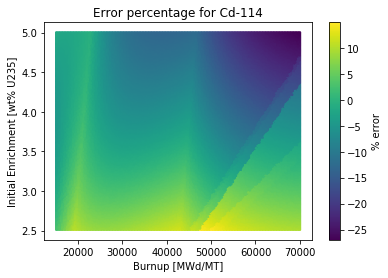

Comparing cd-112


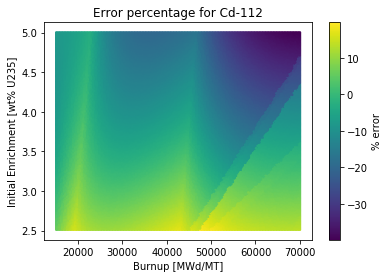

Comparing cm-245


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


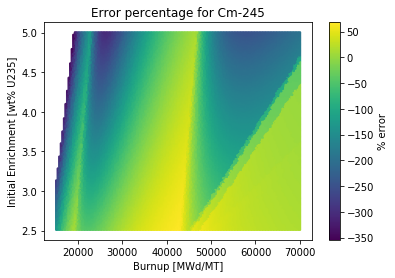

Comparing ba-136


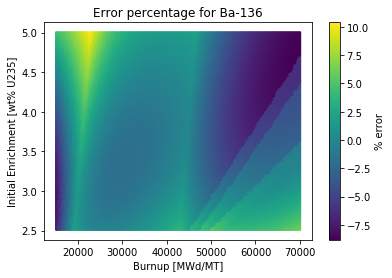

Comparing decay heat


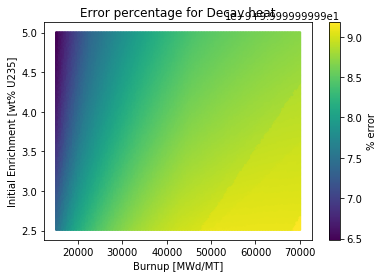

Comparing activity


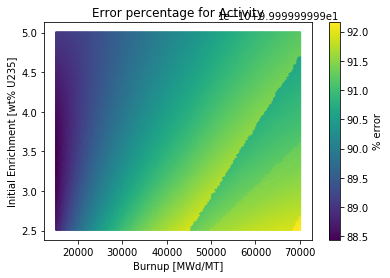

In [124]:
# compare u-238
def compare(column_name):
    print('Comparing', column_name)
    middle_value_indices = df.index[(df['bu'] > 15000) & (df['init_enr'] > 2.5)].tolist()
    bu = df['bu'].values[middle_value_indices]
    enr = df['init_enr'].values[middle_value_indices]
    data = df[column_name].values[middle_value_indices]
    prediction = predict_df[column_name].values[middle_value_indices]
    percent_error = (data - prediction) / data * 100
    plt.scatter(bu, enr, c=percent_error, s=3)
    cbar = plt.colorbar()
    cbar.set_label('% error')
    plt.xlabel('Burnup [MWd/MT]')
    plt.ylabel('Initial Enrichment [wt% U235]')
    plt.title('Error percentage for %s' %column_name.capitalize())
    plt.show()

for columns in ann_model['iso_list'] + ['decay heat', 'activity']:
    compare(columns)

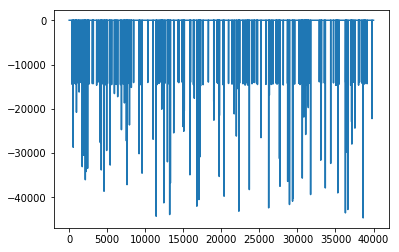

In [126]:
column = 'decay heat'
data = df[column].values
prediction = predict_df[column].values

err = (data - prediction) / data
plt.plot(err)